In [37]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer

import random
import numpy as np

from TRC.utils import tokenize_with_new_mask, evaluate
from TRC.utils_ea import *
from common_utils import mask_batch_seq_generator

In [38]:
MAX_LENGTH = 128
ASSIGN_WEIGHT = True
SEED = 42

In [39]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [40]:
model_name = 'cardiffnlp/twitter-roberta-large-2022-154m'
log_directory = '/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/'

model_path = '/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/saved-model/pytorch_model.bin'
config_path = '/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/saved-model/config.json'

train_data_path = '/home/cc/rora_tesi_new/data/train.p'
test_data_path = '/home/cc/rora_tesi_new/data/test.p'

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = load_local_model(model_path, config_path, device, model_name)
model = model.to(device)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-large-2022-154m were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [42]:
need_columns = ['tweet_tokens', 'sentence_class']

_, Y_train = prepare_data(train_data_path, need_columns)
X_test_raw, Y_test = prepare_data(test_data_path, need_columns)

test_batch_size = Y_test.shape[0]

In [43]:
class_weight = None
if ASSIGN_WEIGHT:
    class_weight = create_weight(Y_train)

In [44]:
tokenizer = AutoTokenizer.from_pretrained(model_name, normalization=True)
X_test, masks_test = tokenize_with_new_mask(X_test_raw, MAX_LENGTH, tokenizer)

num_batches = X_test.shape[0] // test_batch_size
test_batch_generator = mask_batch_seq_generator(X_test, Y_test, masks_test, test_batch_size)

In [46]:
logits, y_true, test_loss, test_auc, test_acc, test_tn, test_fp, test_fn, test_tp, test_precision, test_recall, test_s_pred = evaluate(model,
                                                                                                test_batch_generator,
                                                                                                num_batches, device,
                                                                                                class_weight )

  0%|          | 0/1 [00:00<?, ?it/s]


StopIteration: 

In [33]:
content = f'Test Acc: {test_acc * 100:.2f}%, AUC: {test_auc * 100:.2f}%, TN: {test_tn}, FP: {test_fp}, FN: {test_fn}, TP: {test_tp}, Precision: {test_precision* 100:.2f}%, Recall: {test_recall* 100:.2f}%'
print(content)

Test Acc: 83.74%, AUC: 47.27%, TN: 216, FP: 59, FN: 8, TP: 129, Precision: 68.62%, Recall: 94.16%


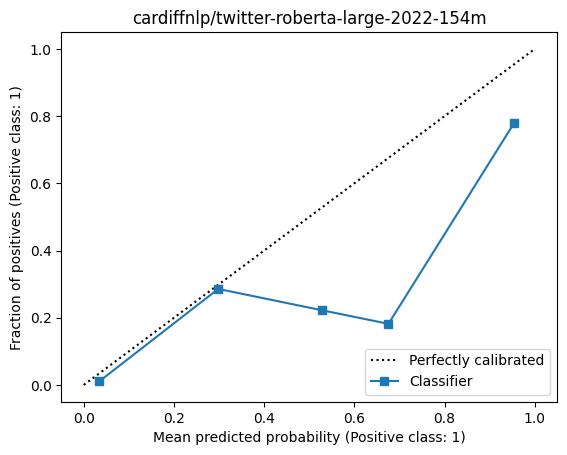

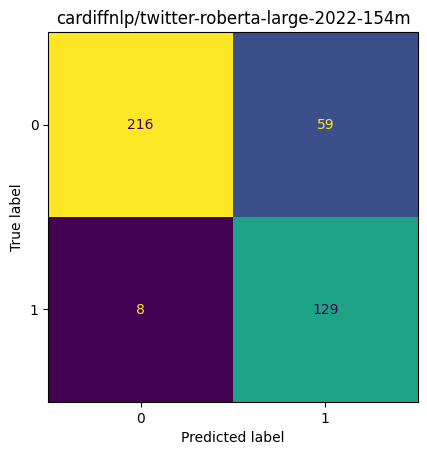

In [34]:
softmax = nn.Softmax(dim=1)
probabilities = softmax(logits)

cal_path = log_directory + 'calibration_curve.png'
calibration_plot(probabilities, y_true = y_true, img_path=cal_path, model_name=model_name)

conf_path = log_directory + 'confusion_matrix.png'
confusion_matrix(probabilities, y_true=y_true, model_name =model_name, path = conf_path)
